# **CONSTANTS & IMPORTS**

Constants

In [4]:
EPOCHS = 300
LEARNING_RATE = 0.001
MANUAL_SEED = 12345
HIDDEN_NODE_COUNT = 64
DATASPLIT = 150
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_TESTING = 1

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Dataset import

In [5]:
import os
import torch
import torch_geometric

from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



dataset = TUDataset(root='dataset/Mutag', name='MUTAG')

data_details = {
    "num_node_features": dataset.num_node_features,
    "num_edge_features": dataset.num_edge_features,
    "num_classes": dataset.num_classes,
    "num_node_labels": dataset.num_node_labels,
    "num_edge_labels": dataset.num_edge_labels,
}

In [6]:
print(data_details)

{'num_node_features': 7, 'num_edge_features': 4, 'num_classes': 2, 'num_node_labels': 7, 'num_edge_labels': 4}


# **DATA SPLITTING**

Shuffle data (optional)

In [7]:
dataset = dataset.shuffle()

Create training set and test set (size defined in constants)

In [8]:
# Allocate for training
train_dataset = dataset[:DATASPLIT]
# Allocate the remainder for testing
test_dataset = dataset[DATASPLIT:]

# Define the data loaders. Used later for training, can be ignored for now
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE_TRAINING, shuffle=True)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE_TESTING, shuffle=False)

%run visualize.py

In [9]:
print(len(train_dataset))
print(len(test_dataset))

150
38


#  **GRAPH VISUALIZATION EXAMPLE**

In [10]:
import networkx as nx
from visualize import GraphVisualization

def create_graph(graph):
    g = to_networkx(graph)
    pos = nx.spring_layout(g)
    vis = GraphVisualization(
        g,
        pos,
        node_text_position="top left",
        node_size=20,
    )
    fig = vis.create_figure()
    return fig


fig = create_graph(dataset[0])
fig.show()

# **GNN MODEL**

Imports


In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

Model definition


In [12]:
class GCN(torch.nn.Module):
    def __init__(self, in_features=dataset.num_node_features, hidden_channels=HIDDEN_NODE_COUNT, outfeatures = 2):
        super(GCN, self).__init__()

        # Input layer
        self.conv1 = GCNConv(in_features, hidden_channels)

        # Hidden layers
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.lin = Linear(hidden_channels, outfeatures)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

Returned data model

In [13]:
class GCNData():
    def __init__(self):
        self.losses = []
        self.accuracies = []
        self.labels = []
        self.scores = []
        self.test_losses = []
        self.test_accuracies = []

# **TRAINING**

In [14]:
from tqdm import trange

Set loss function

In [15]:
loss_function = torch.nn.CrossEntropyLoss()

Basic model training

In [16]:
def hyperParameterTester(create_table=False, hc=HIDDEN_NODE_COUNT, learn=LEARNING_RATE, epochs = EPOCHS):
    
    torch.manual_seed(MANUAL_SEED)                              # Set manual seed
    model = GCN(hidden_channels=hc)                             # Initilialize model

    optimizer = torch.optim.Adam(model.parameters(), lr=learn)  # Set optimizer with learning rate
    loss_function = torch.nn.CrossEntropyLoss()                 # Set loss function

    returnData = GCNData()

    def train(tt):
        model.train()

        for data in train_loader:  # Iterates the batches. We declared each batch to be of size 64

            # Calculate output, and get the maximum of those in order to obtain the predicted value
            out = model(data.x, data.edge_index, data.batch)
            cat = torch.argmax(out, dim=1)

            accuracy = (cat == data.y).float().mean()
            returnData.accuracies.append(accuracy.item())
            loss = loss_function(out, data.y)
            tt.set_description("loss: %2f. accuracy %2f." % (loss, accuracy))
            returnData.losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Append actual and preddicted to respective array. Have to be converted to NumPy arrays in order to flatten them.
            # We flatten them as 1D arrays are required by SK in order to calculate and plot ROC AUC
            arrayLabel = np.array(data.y)
            for value in arrayLabel.flatten():
                returnData.labels.append(value)

            arrayCat = np.array(cat)
            for value in arrayCat.flatten():
                returnData.scores.append(value)


    def test(loader, create):
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)
            cat = torch.argmax(out, dim=1)

            accuracy = (cat == data.y).float().mean()
            returnData.test_accuracies.append(accuracy.item())

            loss = loss_function(out, data.y)
            returnData.test_losses.append(loss.item())

    for epoch in (t := trange(1, epochs)):
        train(t)
        test(train_loader, create_table)
    
    return returnData



# **PLOTTING** 

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as mplstyle

**Plotting helper functions** 

In [44]:
def GraphPrettifier(figname, ylabel, title):
    figure = plt.figure(figname)
    figure.patch.set_facecolor('lightgray')
    plt.xlabel("# Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.legend()

def AvgCalculator(data, numChunks):
    averageOfData = []
    chunkSize = len(data) // numChunks
    for i in range(0, len(data), chunkSize):
        chunk = data[i:i+chunkSize]
        chunkAvg = sum(chunk) / len(chunk)
        averageOfData.append(chunkAvg)
    return averageOfData

Create a class for plotting parameters

In [28]:
class PP():
    def __init__(self, value, colour):
        self.value = value
        self.colour = colour

**Function for plotting the basic graph**

In [50]:
def PlotBasic():
    data = hyperParameterTester() # Get data

    X = np.arange(0, len(data.accuracies))
    plt.figure('g', figsize=[10,5])
    plt.plot(X, np.array(data.accuracies), c="indianred", label="Accuracy")
    plt.plot(X, np.array(data.losses), c="navy", label="Loss")
    GraphPrettifier('g', '', 'Accuracy and Loss')
    plt.show()

**Function for plotting Learning rates**

In [29]:
def PlotOverLR(para: GCNData, cleanGraph=False, numChunks = 50):
    EstNumData = (EPOCHS-1)*len(train_loader)
    X = np.arange(0, (EPOCHS-1)*len(train_loader)) if not cleanGraph else np.arange(0, EstNumData, EstNumData//numChunks)

    for p in para:
        data = hyperParameterTester(learn = p.value) # Get data

        plt.figure('Acc', figsize=[10,5]) # Activate figure with accuracy
        accuracies = np.array(data.accuracies)
        if not cleanGraph: plt.plot(X, accuracies, color=p.colour, label='Learning rate: {}'.format(p.value))

        plt.figure('Loss', figsize=[10,5]) # Activate figure with loss
        losses = np.array(data.losses)
        if not cleanGraph: plt.plot(X, losses, color=p.colour, label='Learning rate: {}'.format(p.value))

        if cleanGraph: # Taking averages for prettier graph
            averageAcc = AvgCalculator(accuracies, numChunks)
            averageLoss = AvgCalculator(losses, numChunks)
            
            plt.figure('Acc') # Activate figure with accuracy
            plt.plot(X, averageAcc, color=p.colour, label='Learning rate: {}'.format(p.value))
            plt.figure('Loss') # Activate figure with loss
            plt.plot(X, averageLoss, color=p.colour, label='Learning rate: {}'.format(p.value))

    script_dir = os.getcwd()
    save_dir = os.path.join(script_dir, 'Figures/LR/')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    save_name = "Accuracy.pdf"
    GraphPrettifier('Acc', 'Accuracy', 'Accuracy with different learning rates')
    plt.savefig(save_dir + save_name)

    save_name = "Loss.pdf"
    GraphPrettifier('Loss', 'Loss', 'Loss with different learning rates')
    plt.savefig(save_dir + save_name)

    plt.show()

**Function for plotting node count**

In [30]:
def PlotOverHC(para: GCNData, cleanGraph=False, numChunks = 50):
    EstNumData = (EPOCHS-1)*len(train_loader)
    X = np.arange(0, (EPOCHS-1)*len(train_loader)) if not cleanGraph else np.arange(0, EstNumData, EstNumData//numChunks)

    for p in para:
        data = hyperParameterTester(hc = p.value) # Get data

        plt.figure('Acc', figsize=[10,5]) # Activate figure with accuracy
        accuracies = np.array(data.accuracies)
        if not cleanGraph: plt.plot(X, accuracies, color=p.colour, label='# Neurons: {}'.format(p.value))

        plt.figure('Loss', figsize=[10,5]) # Activate figure with loss
        losses = np.array(data.losses)
        if not cleanGraph: plt.plot(X, losses, color=p.colour, label='# Neurons: {}'.format(p.value))

        if cleanGraph: # Taking averages for prettier graph
            averageAcc = AvgCalculator(accuracies, numChunks)
            averageLoss = AvgCalculator(losses, numChunks)
            
            plt.figure('Acc') # Activate figure with accuracy
            plt.plot(X, averageAcc, color=p.colour, label='# Neurons: {}'.format(p.value))
            plt.figure('Loss') # Activate figure with loss
            plt.plot(X, averageLoss, color=p.colour, label='# Neurons: {}'.format(p.value))

    script_dir = os.getcwd()
    save_dir = os.path.join(script_dir, 'Figures/HC/')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    save_name = "Accuracy.pdf"
    GraphPrettifier('Acc', 'Accuracy', 'Accuracy with different neurons in the hidden layers')
    plt.savefig(save_dir + save_name)

    save_name = "Loss.pdf"
    GraphPrettifier('Loss', 'Loss', 'Loss with different neurons in the hidden layers')
    plt.savefig(save_dir + save_name)

    plt.show()

**Utilizing the two functions on some parameters**
* Suggested colors: 
    - 'firebrick' 
    - 'lightsalmon' 
    - 'darkgoldenrod'
    - 'goldenrod'
    - 'mediumaquamarine'
    - 'azure' 
    - 'rosybrown'

loss: 0.444449. accuracy 0.816667.: 100%|██████████| 299/299 [00:21<00:00, 13.82it/s]


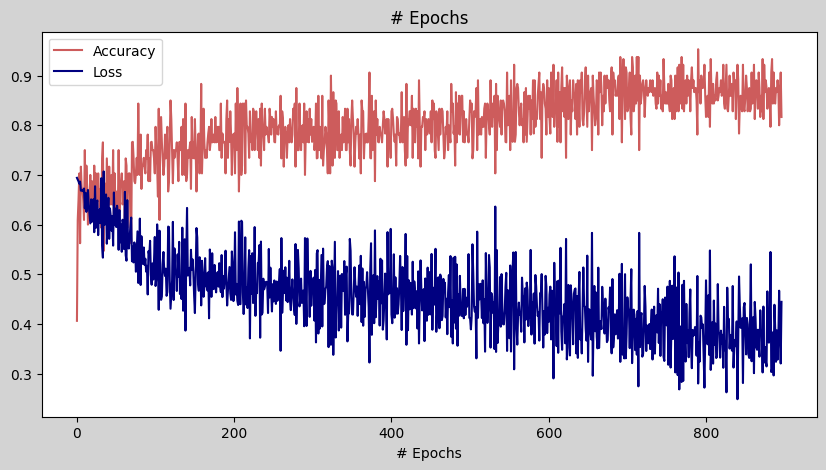

In [52]:
LRparameters = {PP(0.1, 'lightsalmon'), PP(0.01, 'goldenrod'), PP(0.001, 'mediumaquamarine'), PP(0.005, 'rosybrown')}
HCparameters = {PP(5, 'firebrick'), PP(10, 'lightsalmon'), PP(20, 'darkgoldenrod'), PP(40, 'goldenrod'), PP(64, 'mediumaquamarine'), PP(100, 'black'), PP(200, 'rosybrown')}
#PlotOverLR(LRparameters, cleanGraph=True)
#PlotOverHC(HCparameters, cleanGraph=True)
PlotBasic()